In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Kaustade nimed ja klasside määramine
class_names = ["COVID19", "NORMAL", "PNEUMONIA", "TURBERCULOSIS"]
image_data = []
labels = []
# Andmete laadimine
for idx, class_name in enumerate(class_names):
    folder_path = f"Chest X_Ray Dataset/{class_name}"
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image_data.append(img)
        labels.append(idx)  # Määrake klassi indeks

In [3]:
# Muuda andmed numpy massiivideks
image_data = np.array(image_data)
labels = np.array(labels)
# Andmete jaotamine treening-, valideerimis- ja testikomplektideks
X_train, X_test, y_train, y_test = train_test_split(
    image_data, labels, test_size=0.2, random_state=42
)
X_train = X_train / 255.0
X_test = X_test / 255.0

In [4]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)
datagen.fit(X_train)

In [5]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# Kasuta eelnevalt treenitud ResNet50 mudelit
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Ära treeni eelnevalt treenitud kihti

In [6]:
# Täiendame mudelit
model = models.Sequential(
    [
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(4, activation="softmax"),
    ]
)

model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_dir = "model_checkpoints"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Kontrollpunktide salvestamine
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "model_epoch_{epoch:02d}.keras"),
    save_weights_only=False,
    save_best_only=True,  # Salvestab ainult parima mudeli
    monitor="val_loss",  # Jälgib valideerimise kaotust
    mode="min",  # Väiksem valideerimise kaotus on parem
    verbose=1,
)


# Laadige mudel kindlast epohhist
def load_model_from_epoch(checkpoint_dir, epoch_num):
    model_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch_num:02d}.keras")
    if os.path.exists(model_path):
        print(f"Laen mudelit failist: {model_path}")
        return tf.keras.models.load_model(model_path)
    else:
        raise FileNotFoundError(f"Faili {model_path} ei leitud.")


# Laadige mudel 368. epohhist
model = load_model_from_epoch(checkpoint_dir, 955)

Laen mudelit failist: model_checkpoints/model_epoch_955.keras


In [8]:
# Treenime mudelit
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=955,  # mitu epohhi (kui paneme 400 siis treenib 400-368=32 epohhi)
    initial_epoch=955,  # mitmendast epohhist alustab
    callbacks=[checkpoint_callback],  # lisatud........
)

/opt/homebrew/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [9]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, y_pred_classes))
print(classification_report(y_test, y_pred_classes))

45/45 ━━━━━━━━━━━━━━━━━━━━ 35s 738ms/step
[[ 92  15  24   2]
 [  3 238  76   0]
 [  4  53 777   1]
 [ 24   4  30  84]]
              precision    recall  f1-score   support

           0       0.75      0.69      0.72       133
           1       0.77      0.75      0.76       317
           2       0.86      0.93      0.89       835
           3       0.97      0.59      0.73       142

    accuracy                           0.83      1427
   macro avg       0.83      0.74      0.78      1427
weighted avg       0.84      0.83      0.83      1427



<h1>Treeningandmetega ennustamine<h1>


Laen mudelit failist: model_checkpoints/model_epoch_955.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 141s 785ms/step
Õiged ennustused: 4770/5705
Täpsus: 0.84


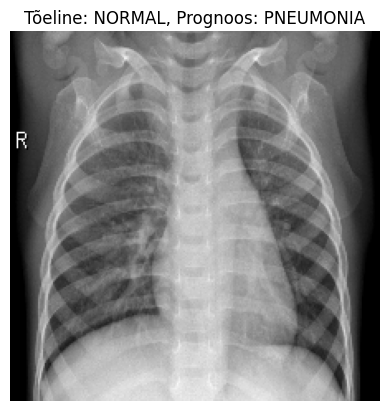

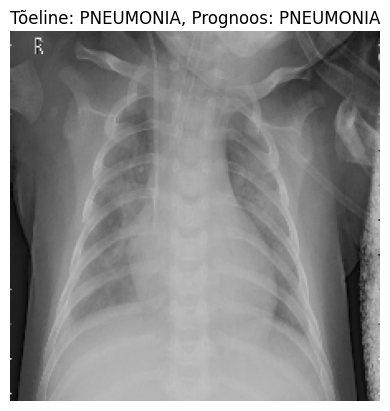

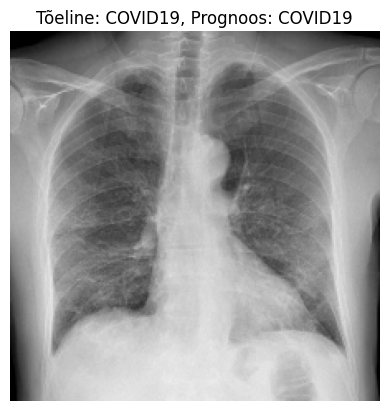

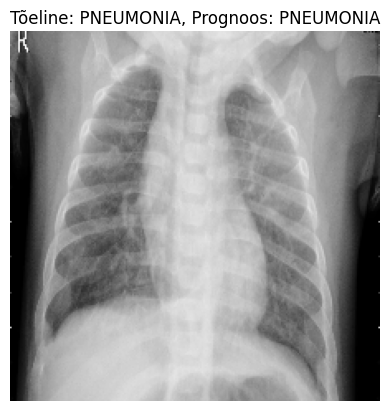

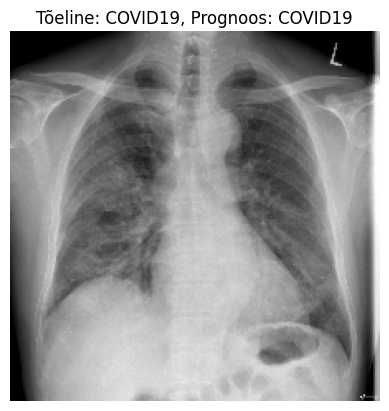

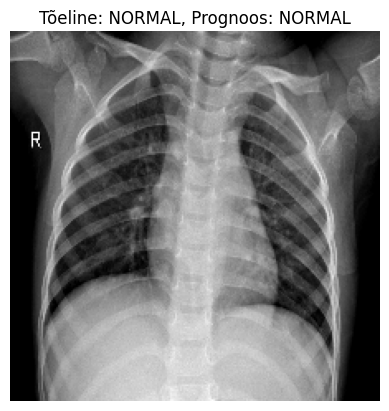

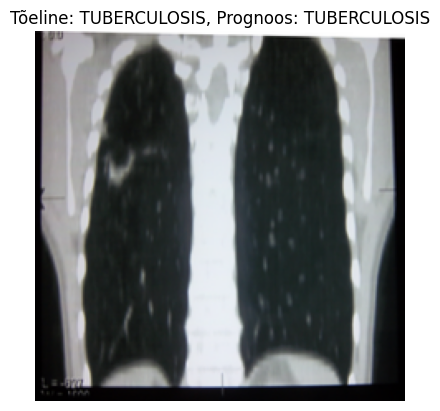

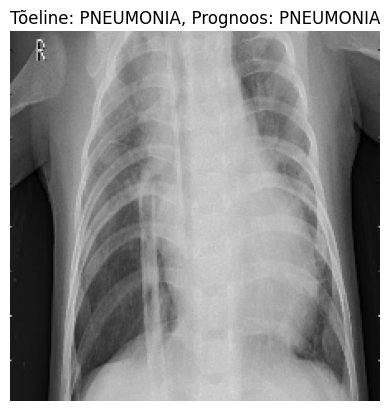

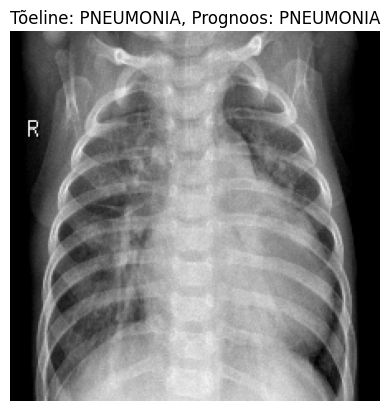

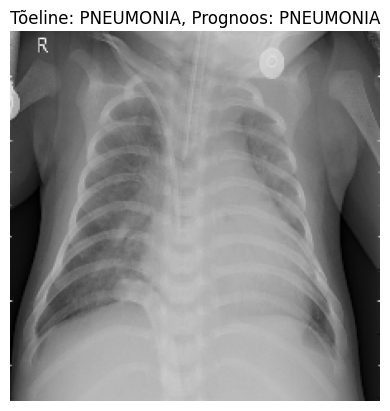

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


# Funktsioon mudeli laadimiseks kindlast epohhist
def load_model_from_epoch(checkpoint_dir, epoch_num):
    model_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch_num:02d}.keras")
    if os.path.exists(model_path):
        print(f"Laen mudelit failist: {model_path}")
        return tf.keras.models.load_model(model_path)
    else:
        raise FileNotFoundError(f"Faili {model_path} ei leitud.")


# Kategooriad
categories = ["COVID19", "NORMAL", "PNEUMONIA", "TUBERCULOSIS"]

# Määrake mudeli kaust
checkpoint_dir = "model_checkpoints"

# Kasutaja sisend epohhi valimiseks
epoch_num = int(input("Sisesta epohhi number, millest mudel laadida: "))
model = load_model_from_epoch(checkpoint_dir, epoch_num)

# Ennustamine treeningandmetega
predictions = model.predict(X_train)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = y_train

# Arvutage õiged ennustused
correct_predictions = np.sum(predicted_classes == true_classes)
total_predictions = len(true_classes)
accuracy = correct_predictions / total_predictions

print(f"Õiged ennustused: {correct_predictions}/{total_predictions}")
print(f"Täpsus: {accuracy:.2f}")

# Kuvame mõned treeningpildid koos ennustuste ja tõeliste klassidega
for i in range(10):  # Kuvame esimesed 10 pilti
    plt.imshow((X_train[i] * 255).astype("uint8"))  # Scale back to [0, 255]
    predicted_class = categories[predicted_classes[i]]
    true_class = categories[true_classes[i]]
    plt.title(f"Tõeline: {true_class}, Prognoos: {predicted_class}")
    plt.axis("off")
    plt.show()